# Group Assignment 4 
## Spatial Analysis of Environmental Racism
BY: Matthew Lach
I will be looking at racial data from the (2019 Census ACS)[https://www.socialexplorer.com/tables/ACS2019_5yr] on a block group level compared to (Toxic Release data from the EPA)[https://enviro.epa.gov/triexplorer/tri_release.chemical?] for each facility in Los Angeles County that is required to register its toxic waste disposal or release. The main demographic that I will be looking at in reference to Toxic Release data is percentage of Hispanic residents. Through the rest of my research, it is evident that many Hispanics in LA are affected by environmental racism. After conducting spatial analysis and spatial autocorrelation, I hope to confirm the results of my other research and analysis.

First, I import all the necessary packages for the work I will do.


In [1]:
# usuals
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import contextily as ctx
from sodapy import Socrata

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps



/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


For my Census data, I am using the collapsed version of the Hispanic by Race table, which I could only find as a .csv from Social Explorer. For this reason, I will do the simple process of converting the DataFrame to a GeoDataFrame by adding geography data to the racial data by the FIPS code. The next several cells will be this process.

In [2]:
# import racial data
df = pd.read_csv('Race-block-group.csv')

In [3]:
# show first 5 rows of dataframe
df.head()

Geo_FIPS            Geo_GEOID       Geo_NAME  \
0  60371011101  15000US060371011101  Block Group 1   
1  60371011102  15000US060371011102  Block Group 2   
2  60371011103  15000US060371011103  Block Group 3   
3  60371011221  15000US060371011221  Block Group 1   
4  60371011222  15000US060371011222  Block Group 2   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Block Group 1, Census Tract 1011.10, Los Angel...         ca         150   
1  Block Group 2, Census Tract 1011.10, Los Angel...         ca         150   
2  Block Group 3, Census Tract 1011.10, Los Angel...         ca         150   
3  Block Group 1, Census Tract 1011.22, Los Angel...         ca         150   
4  Block Group 2, Census Tract 1011.22, Los Angel...         ca         150   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO  Geo_US  ...  SE_B04001_010  \
0            0      ACSSF         14303     NaN  ...            480   
1            0      ACSSF         14304     NaN  ...            545   
2            0      ACSSF         14305     NaN  ...            163   
3            0      ACSSF         14306     NaN  ...            112   
4            0      ACSSF         14307     NaN  ...             35   

   PCT_SE_B04001_002  PCT_SE_B04001_003  PCT_SE_B04001_004  PCT_SE_B04001_005  \
0              71.56              63.27               0.47               0.00   
1              66.23              52.11               0.68               0.19   
2              83.38              72.07               0.00               0.00   
3              94.81              84.04               3.43               0.70   
4              97.20              85.67               0.00               0.00   

   PCT_SE_B04001_006  PCT_SE_B04001_007  PCT_SE_B04001_008  PCT_SE_B04001_009  \
0               2.61               0.00                0.0               5.21   
1              11.09               0.19                0.5               1.49   
2              11.01               0.00                0.0               0.31   
3               4.64               0.00                0.0               1.99   
4               9.61               0.00                0.0               1.92   

   PCT_SE_B04001_010  
0              28.44  
1              33.77  
2              16.62  
3               5.19  
4               2.80  

[5 rows x 74 columns]

In [4]:
# change data types of codes to strings
df = pd.read_csv( 
            "Race-block-group.csv", dtype=
                {
                    "Geo_FIPS":str,
                    "Geo_STATE":str,
                    "Geo_COUNTY":str,
                    "Geo_TRACT":str
                            })
                    
                    

In [5]:
# show columns and corrected data types
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 74 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           6425 non-null   object 
 1   Geo_GEOID          6425 non-null   object 
 2   Geo_NAME           6425 non-null   object 
 3   Geo_QName          6425 non-null   object 
 4   Geo_STUSAB         6425 non-null   object 
 5   Geo_SUMLEV         6425 non-null   int64  
 6   Geo_GEOCOMP        6425 non-null   int64  
 7   Geo_FILEID         6425 non-null   object 
 8   Geo_LOGRECNO       6425 non-null   int64  
 9   Geo_US             0 non-null      float64
 10  Geo_REGION         0 non-null      float64
 11  Geo_DIVISION       0 non-null      float64
 12  Geo_STATECE        0 non-null      float64
 13  Geo_STATE          6425 non-null   object 
 14  Geo_COUNTY         6425 non-null   object 
 15  Geo_COUSUB         0 non-null      float64
 16  Geo_PLACE          0 non

In [6]:
# make a list of rows with null values
df.columns[df.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_STATECE',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_PLACESE',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITSCE',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_UACP',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_VTD',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_TAZ',
 'Geo_UGA',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PUMA5',
 'Geo_PUMA1']

In [7]:
# remove rows with null values
df = df.dropna(axis=1, how="all")
# show 5 rows of cleaned data set
df.head()

Geo_FIPS            Geo_GEOID       Geo_NAME  \
0  060371011101  15000US060371011101  Block Group 1   
1  060371011102  15000US060371011102  Block Group 2   
2  060371011103  15000US060371011103  Block Group 3   
3  060371011221  15000US060371011221  Block Group 1   
4  060371011222  15000US060371011222  Block Group 2   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Block Group 1, Census Tract 1011.10, Los Angel...         ca         150   
1  Block Group 2, Census Tract 1011.10, Los Angel...         ca         150   
2  Block Group 3, Census Tract 1011.10, Los Angel...         ca         150   
3  Block Group 1, Census Tract 1011.22, Los Angel...         ca         150   
4  Block Group 2, Census Tract 1011.22, Los Angel...         ca         150   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE  ... SE_B04001_010  \
0            0      ACSSF         14303        06  ...           480   
1            0      ACSSF         14304        06  ...           545   
2            0      ACSSF         14305        06  ...           163   
3            0      ACSSF         14306        06  ...           112   
4            0      ACSSF         14307        06  ...            35   

  PCT_SE_B04001_002  PCT_SE_B04001_003  PCT_SE_B04001_004  PCT_SE_B04001_005  \
0             71.56              63.27               0.47               0.00   
1             66.23              52.11               0.68               0.19   
2             83.38              72.07               0.00               0.00   
3             94.81              84.04               3.43               0.70   
4             97.20              85.67               0.00               0.00   

   PCT_SE_B04001_006  PCT_SE_B04001_007  PCT_SE_B04001_008  PCT_SE_B04001_009  \
0               2.61               0.00                0.0               5.21   
1              11.09               0.19                0.5               1.49   
2              11.01               0.00                0.0               0.31   
3               4.64               0.00                0.0               1.99   
4               9.61               0.00                0.0               1.92   

   PCT_SE_B04001_010  
0              28.44  
1              33.77  
2              16.62  
3               5.19  
4               2.80  

[5 rows x 32 columns]

In [8]:
# check the info of the new dataframe
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425 entries, 0 to 6424
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Geo_FIPS           6425 non-null   object 
 1   Geo_GEOID          6425 non-null   object 
 2   Geo_NAME           6425 non-null   object 
 3   Geo_QName          6425 non-null   object 
 4   Geo_STUSAB         6425 non-null   object 
 5   Geo_SUMLEV         6425 non-null   int64  
 6   Geo_GEOCOMP        6425 non-null   int64  
 7   Geo_FILEID         6425 non-null   object 
 8   Geo_LOGRECNO       6425 non-null   int64  
 9   Geo_STATE          6425 non-null   object 
 10  Geo_COUNTY         6425 non-null   object 
 11  Geo_TRACT          6425 non-null   object 
 12  Geo_BLKGRP         6425 non-null   int64  
 13  SE_B04001_001      6425 non-null   int64  
 14  SE_B04001_002      6425 non-null   int64  
 15  SE_B04001_003      6425 non-null   int64  
 16  SE_B04001_004      6425 

In [9]:
# drop unnecessary columns

# create list of columns to remove
cols = [14,15,16,17,18,19,20,21,22]

# remove columns
df = df.drop(df.columns[cols], axis=1)

# show all columns in pandas
pd.set_option('display.max_columns', None)

In [10]:
# show first rows of new data
df.head()

Geo_FIPS            Geo_GEOID       Geo_NAME  \
0  060371011101  15000US060371011101  Block Group 1   
1  060371011102  15000US060371011102  Block Group 2   
2  060371011103  15000US060371011103  Block Group 3   
3  060371011221  15000US060371011221  Block Group 1   
4  060371011222  15000US060371011222  Block Group 2   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Block Group 1, Census Tract 1011.10, Los Angel...         ca         150   
1  Block Group 2, Census Tract 1011.10, Los Angel...         ca         150   
2  Block Group 3, Census Tract 1011.10, Los Angel...         ca         150   
3  Block Group 1, Census Tract 1011.22, Los Angel...         ca         150   
4  Block Group 2, Census Tract 1011.22, Los Angel...         ca         150   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
0            0      ACSSF         14303        06        037    101110   
1            0      ACSSF         14304        06        037    101110   
2            0      ACSSF         14305        06        037    101110   
3            0      ACSSF         14306        06        037    101122   
4            0      ACSSF         14307        06        037    101122   

   Geo_BLKGRP  SE_B04001_001  PCT_SE_B04001_002  PCT_SE_B04001_003  \
0           1           1688              71.56              63.27   
1           2           1614              66.23              52.11   
2           3            981              83.38              72.07   
3           1           2156              94.81              84.04   
4           2           1249              97.20              85.67   

   PCT_SE_B04001_004  PCT_SE_B04001_005  PCT_SE_B04001_006  PCT_SE_B04001_007  \
0               0.47               0.00               2.61               0.00   
1               0.68               0.19              11.09               0.19   
2               0.00               0.00              11.01               0.00   
3               3.43               0.70               4.64               0.00   
4               0.00               0.00               9.61               0.00   

   PCT_SE_B04001_008  PCT_SE_B04001_009  PCT_SE_B04001_010  
0                0.0               5.21              28.44  
1                0.5               1.49              33.77  
2                0.0               0.31              16.62  
3                0.0               1.99               5.19  
4                0.0               1.92               2.80

In [11]:
# list column names to rename them 
columns=list(df)
columns

['Geo_FIPS',
 'Geo_GEOID',
 'Geo_NAME',
 'Geo_QName',
 'Geo_STUSAB',
 'Geo_SUMLEV',
 'Geo_GEOCOMP',
 'Geo_FILEID',
 'Geo_LOGRECNO',
 'Geo_STATE',
 'Geo_COUNTY',
 'Geo_TRACT',
 'Geo_BLKGRP',
 'SE_B04001_001',
 'PCT_SE_B04001_002',
 'PCT_SE_B04001_003',
 'PCT_SE_B04001_004',
 'PCT_SE_B04001_005',
 'PCT_SE_B04001_006',
 'PCT_SE_B04001_007',
 'PCT_SE_B04001_008',
 'PCT_SE_B04001_009',
 'PCT_SE_B04001_010']

In [12]:
# rename columns to desired names
df.columns = ['Geo_FIPS',
 'Geo_GEOID',
 'Geo_NAME',
 'Geo_QName',
 'Geo_STUSAB',
 'Geo_SUMLEV',
 'Geo_GEOCOMP',
 'Geo_FILEID',
 'Geo_LOGRECNO',
 'Geo_STATE',
 'Geo_COUNTY',
 'Geo_TRACT',
 'Geo_BLKGRP',
 'Total_Population',
 'PCT_Not_Hispanic',
 'PCT_White',
 'PCT_Black',
 'PCT_American_Indian',
 'PCT_Asian',
 'PCT_Pacific_Islander',
 'PCT_Other',
 'PCT_Two_or_more',
 'PCT_Hispanic']

In [13]:
# import geography data for census block groups
Geo = gpd.read_file("2010_Census_Block_Groups.geojson")

In [14]:
# limit columns to necesary columns
Geo = Geo[['GEOID10', 'geometry']]

In [15]:
# rename Geo columns to match original dataframe
Geo.columns = ['Geo_FIPS','geometry']
# check the data
Geo.head()

Geo_FIPS                                           geometry
0  060372932023  POLYGON ((-118.29910 33.81975, -118.29918 33.8...
1  060372941201  POLYGON ((-118.24598 33.80005, -118.24600 33.8...
2  060372932022  POLYGON ((-118.29908 33.82230, -118.29930 33.8...
3  060372932021  POLYGON ((-118.29920 33.82570, -118.29939 33.8...
4  060372941101  POLYGON ((-118.25846 33.79945, -118.25754 33.8...

In [16]:
# merge the dataframes based on FIPS codes
blocks_Race = Geo.merge(df, on = "Geo_FIPS")
# check data
blocks_Race.head()

Geo_FIPS                                           geometry  \
0  060372932023  POLYGON ((-118.29910 33.81975, -118.29918 33.8...   
1  060372941201  POLYGON ((-118.24598 33.80005, -118.24600 33.8...   
2  060372932022  POLYGON ((-118.29908 33.82230, -118.29930 33.8...   
3  060372932021  POLYGON ((-118.29920 33.82570, -118.29939 33.8...   
4  060372941101  POLYGON ((-118.25846 33.79945, -118.25754 33.8...   

             Geo_GEOID       Geo_NAME  \
0  15000US060372932023  Block Group 3   
1  15000US060372941201  Block Group 1   
2  15000US060372932022  Block Group 2   
3  15000US060372932021  Block Group 1   
4  15000US060372941101  Block Group 1   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Block Group 3, Census Tract 2932.02, Los Angel...         ca         150   
1  Block Group 1, Census Tract 2941.20, Los Angel...         ca         150   
2  Block Group 2, Census Tract 2932.02, Los Angel...         ca         150   
3  Block Group 1, Census Tract 2932.02, Los Angel...         ca         150   
4  Block Group 1, Census Tract 2941.10, Los Angel...         ca         150   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
0            0      ACSSF         16693        06        037    293202   
1            0      ACSSF         16706        06        037    294120   
2            0      ACSSF         16692        06        037    293202   
3            0      ACSSF         16691        06        037    293202   
4            0      ACSSF         16703        06        037    294110   

   Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
0           3              3494             30.19       5.18      11.10   
1           1               711              6.47       0.98       5.49   
2           2              2460             25.33       1.30       4.23   
3           1               786             37.91      14.38       3.94   
4           1              1793             11.32       5.86       0.00   

   PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
0                  0.0      11.88                  0.00       0.00   
1                  0.0       0.00                  0.00       0.00   
2                  0.0      18.98                  0.00       0.81   
3                  0.0      16.16                  0.00       0.00   
4                  0.0       0.00                  1.28       0.00   

   PCT_Two_or_more  PCT_Hispanic  
0             2.03         69.81  
1             0.00         93.53  
2             0.00         74.67  
3             3.44         62.09  
4             4.18         88.68

### Importing and Cleaning TRI Data
Now that we have the Census data by block group including the geometry, we will bring the data from the EPA and clean up the csv. This dataset shows the name, latitude, longitude, and total toxic disposal of each location in Los Angeles County. I will also have to add geometry data for the longitude and latitude of each location.

In [17]:
# import EPA data as tri
tri = pd.read_csv('fac_release.csv')

In [18]:
# show first rows of data
tri.head()

Row #                                           Facility  Latitude  \
0      1  3M CO - MONROVIA TAPE.1601 S SHAMROCK AVE, MON...    34.134   
1      2  3M UNITEK.2724 SOUTH PECK ROAD, MONROVIA CALIF...    34.115   
2      3  A&A READY MIXED CONCRETE INC.100 E. REDONDO BE...    33.893   
3      4  A&A READY MIXED CONCRETE INC.134 W. REDONDO BE...    33.893   
4      5  A&A READY MIXED CONCRETE INC.900 E. PATTERSON ...    33.807   

   Longitude Total On- and Off-site Disposal or Other Releases  
0   -117.991                                          2,331.60  
1   -118.004                                          1,548.40  
2   -118.276                                                 0  
3   -118.278                                                 0  
4   -118.182                                                 0

In [19]:
# check the data types and null counts of data
tri.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Row #                                              356 non-null    int64  
 1   Facility                                           356 non-null    object 
 2   Latitude                                           356 non-null    float64
 3   Longitude                                          356 non-null    float64
 4   Total On- and Off-site Disposal or Other Releases  356 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 14.0+ KB


In [20]:
# we have an unnecesary row called 'Row #'

# drop the first row
tri = tri.drop(tri.columns[0], axis=1)
# show new data set
tri.head()

Facility  Latitude  Longitude  \
0  3M CO - MONROVIA TAPE.1601 S SHAMROCK AVE, MON...    34.134   -117.991   
1  3M UNITEK.2724 SOUTH PECK ROAD, MONROVIA CALIF...    34.115   -118.004   
2  A&A READY MIXED CONCRETE INC.100 E. REDONDO BE...    33.893   -118.276   
3  A&A READY MIXED CONCRETE INC.134 W. REDONDO BE...    33.893   -118.278   
4  A&A READY MIXED CONCRETE INC.900 E. PATTERSON ...    33.807   -118.182   

  Total On- and Off-site Disposal or Other Releases  
0                                          2,331.60  
1                                          1,548.40  
2                                                 0  
3                                                 0  
4                                                 0

In [21]:
# convert long and lat to point geometry

# import Point from shapely 
from shapely.geometry import Point

In [22]:
# create geometry variable for point data
geometry = [Point(xy) for xy in zip(tri['Longitude'], tri["Latitude"])]
geometry[:3]

In [23]:
# create gdf from tri data
tri_map = gpd.GeoDataFrame(tri,
                           crs='epsg:4326',
                           geometry=geometry # assign geometry data to gdf
                          )

# show new gdf
tri_map.head()

Facility  Latitude  Longitude  \
0  3M CO - MONROVIA TAPE.1601 S SHAMROCK AVE, MON...    34.134   -117.991   
1  3M UNITEK.2724 SOUTH PECK ROAD, MONROVIA CALIF...    34.115   -118.004   
2  A&A READY MIXED CONCRETE INC.100 E. REDONDO BE...    33.893   -118.276   
3  A&A READY MIXED CONCRETE INC.134 W. REDONDO BE...    33.893   -118.278   
4  A&A READY MIXED CONCRETE INC.900 E. PATTERSON ...    33.807   -118.182   

  Total On- and Off-site Disposal or Other Releases  \
0                                          2,331.60   
1                                          1,548.40   
2                                                 0   
3                                                 0   
4                                                 0   

                      geometry  
0  POINT (-117.99100 34.13400)  
1  POINT (-118.00400 34.11500)  
2  POINT (-118.27600 33.89300)  
3  POINT (-118.27800 33.89300)  
4  POINT (-118.18200 33.80700)

In [24]:
# change to mercator projection
tri_map = tri_map.to_crs(epsg=3857)

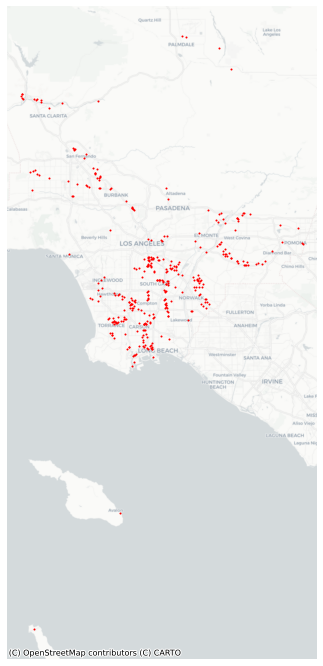

In [25]:
# create subplot
fig,ax = plt.subplots(figsize=(12,12))

# map locations of TR facilities 
tri_map.plot(ax=ax,
             color='red',
             markersize=1)

# no axis
ax.axis('off')

# add a basemap from carto
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [26]:
# find bounds of points from locations
minx, miny, maxx, maxy = tri_map.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13205831.192806043
-13105421.012110509
3898357.2267849366
4110060.4555166573


In [27]:
# convert to mercator projection for plot
blocks_Race = blocks_Race.to_crs(epsg=3857)

### Plotting TRI Data
Now that we have the TRI data in a GeoDataFrame, we can plot this data as an overlay on maps of Census data. I will make two maps with the locations of each toxic release location overlayed on a choropleth of percentage of hispanic and percentage of black residents in each block group.

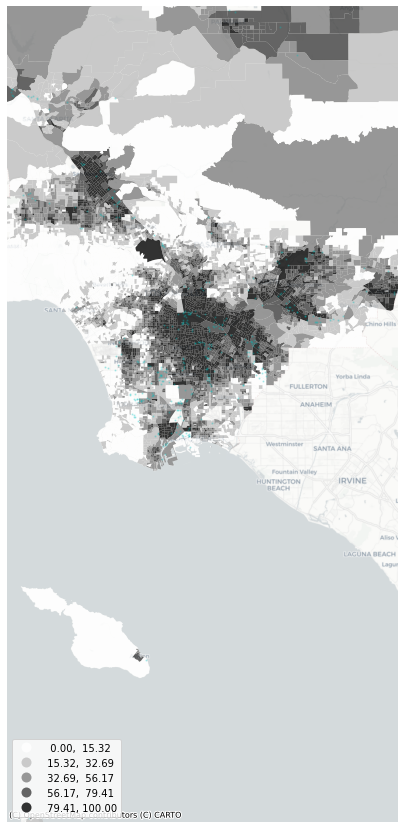

In [28]:

# make the plot
fig,ax = plt.subplots(figsize=(20, 15)) 

# create choropleth base map based on pct hispanic
blocks_Race.plot(ax=ax,
                   column="PCT_Hispanic",
                   cmap='gray_r',
                   legend=True,
                   alpha=0.8,
                   scheme="quantiles")

# plot each location on the choropleth
tri_map.plot(ax=ax, 
            color='c',
            markersize=1.5,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) 
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap from carto
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


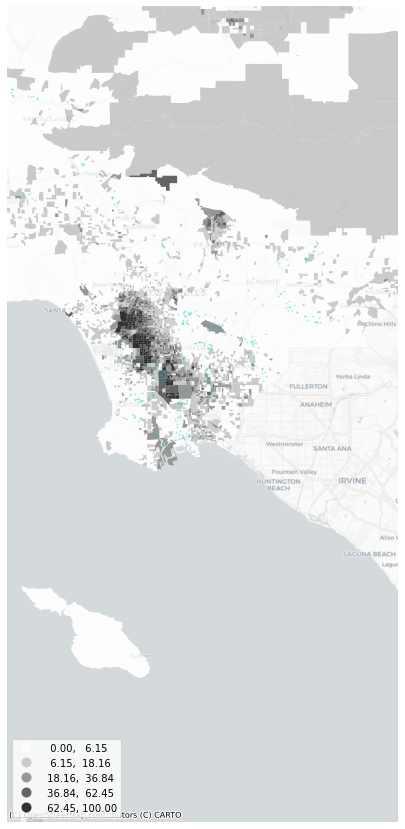

In [29]:

# plot map
fig,ax = plt.subplots(figsize=(20, 15)) 

# define base map
blocks_Race.plot(ax=ax,
                   column="PCT_Black",
                   cmap='gray_r',
                   legend=True,
                   alpha=0.8,
                   scheme="naturalbreaks")

# arrests
tri_map.plot(ax=ax, # this also puts it in the same ax plot
            color='c',
            markersize=1.5,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Based on the results of these two overlays, there appears to be some significance of clustering in areas of high concentration of hispanic residents. This is seen predominantly in the Downtown LA area and its surrounding neighborhoods. There are also a few instances of clusters around predominantly black neighborhoods, especially in the Compton and Inglewood area. However, we still need to conduct spatial analysis to determine the statistical significance of these clusters.

## Spatial Analysis of TRI and Census Data
Now that both the TRI and Census data are clean, we can combine the two data frames in order to do our spatial analysis.

In [30]:
# join TRI and ACS data to the left
join = gpd.sjoin(tri_map, blocks_Race, how='left')
join.head()

Facility  Latitude  Longitude  \
0  3M CO - MONROVIA TAPE.1601 S SHAMROCK AVE, MON...    34.134   -117.991   
1  3M UNITEK.2724 SOUTH PECK ROAD, MONROVIA CALIF...    34.115   -118.004   
2  A&A READY MIXED CONCRETE INC.100 E. REDONDO BE...    33.893   -118.276   
3  A&A READY MIXED CONCRETE INC.134 W. REDONDO BE...    33.893   -118.278   
4  A&A READY MIXED CONCRETE INC.900 E. PATTERSON ...    33.807   -118.182   

  Total On- and Off-site Disposal or Other Releases  \
0                                          2,331.60   
1                                          1,548.40   
2                                                 0   
3                                                 0   
4                                                 0   

                            geometry  index_right      Geo_FIPS  \
0  POINT (-13134698.038 4046809.176)       5620.0  060374311001   
1  POINT (-13136145.192 4044254.189)       2472.0  060374046002   
2  POINT (-13166424.093 4014443.573)         75.0  060375410011   
3  POINT (-13166646.732 4014443.573)         75.0  060375410011   
4  POINT (-13155960.061 4002916.189)        240.0  060375734011   

             Geo_GEOID       Geo_NAME  \
0  15000US060374311001  Block Group 1   
1  15000US060374046002  Block Group 2   
2  15000US060375410011  Block Group 1   
3  15000US060375410011  Block Group 1   
4  15000US060375734011  Block Group 1   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Block Group 1, Census Tract 4311, Los Angeles ...         ca       150.0   
1  Block Group 2, Census Tract 4046, Los Angeles ...         ca       150.0   
2  Block Group 1, Census Tract 5410.01, Los Angel...         ca       150.0   
3  Block Group 1, Census Tract 5410.01, Los Angel...         ca       150.0   
4  Block Group 1, Census Tract 5734.01, Los Angel...         ca       150.0   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
0          0.0      ACSSF       17663.0        06        037    431100   
1          0.0      ACSSF       17323.0        06        037    404600   
2          0.0      ACSSF       18786.0        06        037    541001   
3          0.0      ACSSF       18786.0        06        037    541001   
4          0.0      ACSSF       19445.0        06        037    573401   

   Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
0         1.0            2063.0             38.25       9.36       0.58   
1         2.0             503.0              0.00       0.00       0.00   
2         1.0            1144.0             60.23       3.67      48.69   
3         1.0            1144.0             60.23       3.67      48.69   
4         1.0            1642.0             62.79      25.64      16.99   

   PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
0                  0.0      27.39                   0.0        0.0   
1                  0.0       0.00                   0.0        0.0   
2                  0.0       7.87                   0.0        0.0   
3                  0.0       7.87                   0.0        0.0   
4                  0.0      18.15                   0.0        0.0   

   PCT_Two_or_more  PCT_Hispanic  
0             0.92         61.75  
1             0.00        100.00  
2             0.00         39.77  
3             0.00         39.77  
4             2.01         37.21

In [31]:
# sum the results by FIPS code
tri_by_blocks = join.groupby(["Geo_FIPS","Total_Population","PCT_Hispanic","PCT_American_Indian","PCT_Black"]).index_right.sum().reset_index()
tri_by_blocks.head()

Geo_FIPS  Total_Population  PCT_Hispanic  PCT_American_Indian  \
0  060371047031            1221.0         81.16                 0.00   
1  060371065202            2030.0         89.11                 0.00   
2  060371065203            1457.0         99.31                 0.00   
3  060371132371            2878.0         29.71                 0.00   
4  060371133032            1749.0         35.68                 0.91   

   PCT_Black  index_right  
0      12.20       2984.0  
1       0.69        630.0  
2       0.00       5316.0  
3      12.79       1860.0  
4       3.03      15828.0

This result gives a clean data set that we can merge with our previous blocks_Race dataframe. First, I will limit the columns to just the FIPS code and the corresponding Total Toxic Release.

In [32]:
# limit columns of TRI data
TRI = tri_by_blocks[['index_right','Geo_FIPS']]

In [33]:
# rename TRI columns
TRI.columns = ['Total_TRI','Geo_FIPS']

In [34]:
# merge TRI and blocks_race based on FIPS 
blocks_Race = blocks_Race.merge(TRI,on="Geo_FIPS")

In [35]:
# show first rows of new dataframe
blocks_Race.head()

Geo_FIPS                                           geometry  \
0  060372941203  POLYGON ((-13162510.563 4000812.463, -13162455...   
1  060375702032  POLYGON ((-13153514.835 4012963.645, -13153569...   
2  060375538021  POLYGON ((-13153513.054 4013925.509, -13153527...   
3  060375538022  POLYGON ((-13154486.432 4013919.609, -13154623...   
4  060375410011  POLYGON ((-13166199.693 4015646.285, -13166295...   

             Geo_GEOID       Geo_NAME  \
0  15000US060372941203  Block Group 3   
1  15000US060375702032  Block Group 2   
2  15000US060375538021  Block Group 1   
3  15000US060375538022  Block Group 2   
4  15000US060375410011  Block Group 1   

                                           Geo_QName Geo_STUSAB  Geo_SUMLEV  \
0  Block Group 3, Census Tract 2941.20, Los Angel...         ca         150   
1  Block Group 2, Census Tract 5702.03, Los Angel...         ca         150   
2  Block Group 1, Census Tract 5538.02, Los Angel...         ca         150   
3  Block Group 2, Census Tract 5538.02, Los Angel...         ca         150   
4  Block Group 1, Census Tract 5410.01, Los Angel...         ca         150   

   Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
0            0      ACSSF         16708        06        037    294120   
1            0      ACSSF         19273        06        037    570203   
2            0      ACSSF         19148        06        037    553802   
3            0      ACSSF         19149        06        037    553802   
4            0      ACSSF         18786        06        037    541001   

   Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
0           3               735             17.82       6.53       5.85   
1           2              1589             36.63       1.13      33.98   
2           1              1068             50.37       9.08      32.30   
3           2              3313             20.83       9.60       8.18   
4           1              1144             60.23       3.67      48.69   

   PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
0                  0.0       5.44                   0.0       0.00   
1                  0.0       0.00                   0.0       0.00   
2                  0.0       8.15                   0.0       0.00   
3                  0.3       2.51                   0.0       0.24   
4                  0.0       7.87                   0.0       0.00   

   PCT_Two_or_more  PCT_Hispanic  Total_TRI  
0             0.00         82.18       50.0  
1             1.51         63.37      108.0  
2             0.84         49.63       64.0  
3             0.00         79.17       73.0  
4             0.00         39.77      525.0

In [36]:
# sort values based on TR and show top 5 
blocks_Race.sort_values(by='Total_TRI').tail()

Geo_FIPS                                           geometry  \
133  060374082111  POLYGON ((-13126666.017 4030400.134, -13126727...   
139  060375323042  POLYGON ((-13153510.828 4028312.180, -13154036...   
91   060374082022  POLYGON ((-13132226.538 4033445.397, -13132273...   
138  060375027002  POLYGON ((-13142378.654 4024682.371, -13142391...   
117  060375324001  POLYGON ((-13158279.311 4030677.990, -13158294...   

               Geo_GEOID       Geo_NAME  \
133  15000US060374082111  Block Group 1   
139  15000US060375323042  Block Group 2   
91   15000US060374082022  Block Group 2   
138  15000US060375027002  Block Group 2   
117  15000US060375324001  Block Group 1   

                                             Geo_QName Geo_STUSAB  Geo_SUMLEV  \
133  Block Group 1, Census Tract 4082.11, Los Angel...         ca         150   
139  Block Group 2, Census Tract 5323.04, Los Angel...         ca         150   
91   Block Group 2, Census Tract 4082.02, Los Angel...         ca         150   
138  Block Group 2, Census Tract 5027, Los Angeles ...         ca         150   
117  Block Group 1, Census Tract 5324, Los Angeles ...         ca         150   

     Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
133            0      ACSSF         17524        06        037    408211   
139            0      ACSSF         18514        06        037    532304   
91             0      ACSSF         17523        06        037    408202   
138            0      ACSSF         18295        06        037    502700   
117            0      ACSSF         18515        06        037    532400   

     Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
133           1               909             50.61       6.27       0.00   
139           2              1101             36.42       9.90      24.34   
91            2              1013             11.94       2.76       0.00   
138           2              1390             35.47      20.50       2.37   
117           1                45             20.00      17.78       2.22   

     PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
133                 0.00      44.11                   0.0       0.00   
139                 1.91       0.27                   0.0       0.00   
91                  0.00       4.94                   0.0       2.57   
138                 0.50       4.89                   0.0       5.18   
117                 0.00       0.00                   0.0       0.00   

     PCT_Two_or_more  PCT_Hispanic  Total_TRI  
133             0.22         49.39    33690.0  
139             0.00         63.58    34572.0  
91              1.68         88.06    44341.0  
138             2.01         64.53    45984.0  
117             0.00         80.00    72618.0

Now that the data set is clean, we need to weigh the Total TRI variable with another variable from the Census. I will do this by multiplying the percentage of Hispanic residents in each block group by the total toxic release in that block group. I will output this new variable in a new row for further analysis.

In [37]:
# weight total TRI by pct hispanic
blocks_Race['TRI_by_demo'] = blocks_Race['Total_TRI']*(blocks_Race['PCT_Hispanic']*.01)

In [38]:
# show 10 highest TRI by percent hispanic 
blocks_Race.sort_values(by="TRI_by_demo").tail(10)

Geo_FIPS                                           geometry  \
133  060374082111  POLYGON ((-13126666.017 4030400.134, -13126727...   
157  060375361023  POLYGON ((-13154657.307 4022641.495, -13154669...   
67   060374046002  POLYGON ((-13127837.100 4046753.213, -13127837...   
139  060375323042  POLYGON ((-13153510.828 4028312.180, -13154036...   
136  060375323033  POLYGON ((-13151980.408 4031230.102, -13152004...   
148  060375325001  POLYGON ((-13160483.326 4027670.388, -13160592...   
156  060375360001  POLYGON ((-13157161.663 4023650.613, -13157168...   
138  060375027002  POLYGON ((-13142378.654 4024682.371, -13142391...   
91   060374082022  POLYGON ((-13132226.538 4033445.397, -13132273...   
117  060375324001  POLYGON ((-13158279.311 4030677.990, -13158294...   

               Geo_GEOID       Geo_NAME  \
133  15000US060374082111  Block Group 1   
157  15000US060375361023  Block Group 3   
67   15000US060374046002  Block Group 2   
139  15000US060375323042  Block Group 2   
136  15000US060375323033  Block Group 3   
148  15000US060375325001  Block Group 1   
156  15000US060375360001  Block Group 1   
138  15000US060375027002  Block Group 2   
91   15000US060374082022  Block Group 2   
117  15000US060375324001  Block Group 1   

                                             Geo_QName Geo_STUSAB  Geo_SUMLEV  \
133  Block Group 1, Census Tract 4082.11, Los Angel...         ca         150   
157  Block Group 3, Census Tract 5361.02, Los Angel...         ca         150   
67   Block Group 2, Census Tract 4046, Los Angeles ...         ca         150   
139  Block Group 2, Census Tract 5323.04, Los Angel...         ca         150   
136  Block Group 3, Census Tract 5323.03, Los Angel...         ca         150   
148  Block Group 1, Census Tract 5325, Los Angeles ...         ca         150   
156  Block Group 1, Census Tract 5360, Los Angeles ...         ca         150   
138  Block Group 2, Census Tract 5027, Los Angeles ...         ca         150   
91   Block Group 2, Census Tract 4082.02, Los Angel...         ca         150   
117  Block Group 1, Census Tract 5324, Los Angeles ...         ca         150   

     Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
133            0      ACSSF         17524        06        037    408211   
157            0      ACSSF         18721        06        037    536102   
67             0      ACSSF         17323        06        037    404600   
139            0      ACSSF         18514        06        037    532304   
136            0      ACSSF         18512        06        037    532303   
148            0      ACSSF         18516        06        037    532500   
156            0      ACSSF         18717        06        037    536000   
138            0      ACSSF         18295        06        037    502700   
91             0      ACSSF         17523        06        037    408202   
117            0      ACSSF         18515        06        037    532400   

     Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
133           1               909             50.61       6.27       0.00   
157           3              1602             32.52      32.52       0.00   
67            2               503              0.00       0.00       0.00   
139           2              1101             36.42       9.90      24.34   
136           3               963              2.70       0.00       0.00   
148           1              1302              6.45       1.15       5.30   
156           1              1127              2.84       1.60       0.00   
138           2              1390             35.47      20.50       2.37   
91            2              1013             11.94       2.76       0.00   
117           1                45             20.00      17.78       2.22   

     PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
133                 0.00      44.11                  0.00       0.00   
157                 0

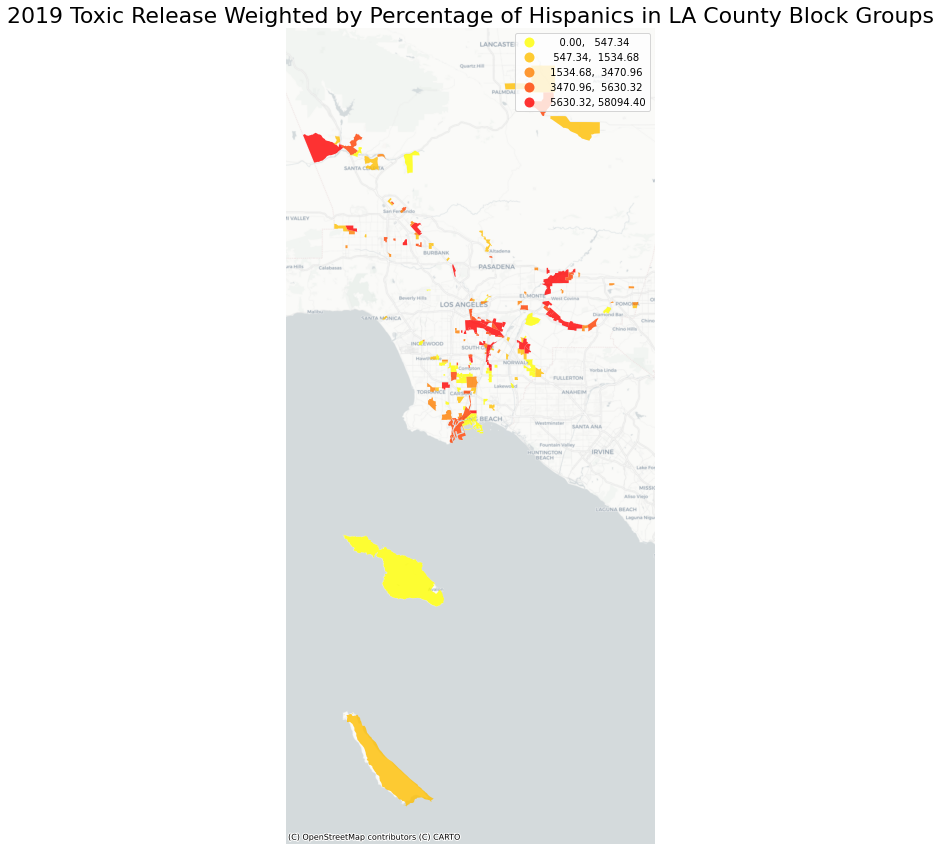

In [39]:
# make choropleth plot of tri_by_demo
fig,ax = plt.subplots(figsize=(15,15))

blocks_Race.plot(ax=ax,
        column='TRI_by_demo',
        legend=True,
        alpha=0.8,
        cmap='autumn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('2019 Toxic Release Weighted by Percentage of Hispanics in LA County Block Groups',fontsize=22)
# add carto basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Based on the results of this choropleth, there does appear to be some significant grouping of high-percentage Hispanic communities experiencing higher levels of toxic release. This is most evident in the southern regions below Downtown LA. This is not however a definitive display of spatial autocorrelation when it comes to this variable. Because there are many block groups with no TRI, it will be interesting to see the results of the autocorrelation and I may need to look to combine this data with other environmental factors to improve the results.

### Spatial Lag and Lag Difference
Next, I will add the spatial weight and calculate the spatail lag for the TRI_by_demo variable. I will also use the result of the TRI_by_demo and its spatial lag to calculate spatial lag difference. With these two variables I will be able to complete the rest of the spatial analysis

In [40]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(blocks_Race,k=8)

# Row-standardization
wq.transform = 'r'

In [41]:
# create a new column for the spatial lag
blocks_Race['TRI_by_demo_lag'] = lps.weights.lag_spatial(wq, blocks_Race['TRI_by_demo'])

In [42]:
# show sample of important columns
blocks_Race.sample(10)[['PCT_Hispanic','Total_TRI','TRI_by_demo','TRI_by_demo_lag']]

PCT_Hispanic  Total_TRI  TRI_by_demo  TRI_by_demo_lag
73          47.37    14305.0    6776.2785      1571.982038
153         64.46     6223.0    4011.3458      6954.109400
39          72.73     1296.0     942.5808      2129.965187
113         82.31    14850.0   12223.0350      3925.160188
155         83.62     6332.0    5294.8184      9971.704163
25          89.43      789.0     705.6027      6827.577837
143         58.41    11622.0    6788.4102      5012.855250
52          12.75     1960.0     249.9000      2531.724050
15          51.23      400.0     204.9200      1838.648438
158         95.46     6343.0    6055.0278     13104.425675

In [43]:
# calculate lag difference
blocks_Race['TRI_lag_diff'] = blocks_Race['TRI_by_demo'] - blocks_Race['TRI_by_demo_lag']

In [44]:
# rename gdf and remove null lag differences
# this is because the Moran was not working with null values
blocks_Race1 = blocks_Race[blocks_Race['TRI_lag_diff'].notna()]

### Donut and Diamond
Now that we have the spatial lag and lag difference, we can find the donut and diamond of our data and plot them. The donut will be the block group with the smallest lag difference and the diamond is the one with the highest.

In [45]:
# find donut by sorting
blocks_Race1_donut = blocks_Race1.sort_values(by='TRI_lag_diff').head(1)
blocks_Race1_donut

Geo_FIPS                                           geometry  \
101  060375332012  POLYGON ((-13158413.451 4026532.840, -13158425...   

               Geo_GEOID       Geo_NAME  \
101  15000US060375332012  Block Group 2   

                                             Geo_QName Geo_STUSAB  Geo_SUMLEV  \
101  Block Group 2, Census Tract 5332.01, Los Angel...         ca         150   

     Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
101            0      ACSSF         18553        06        037    533201   

     Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
101           2              1794              3.07       3.07        0.0   

     PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
101                  0.0        0.0                   0.0        0.0   

     PCT_Two_or_more  PCT_Hispanic  Total_TRI  TRI_by_demo  TRI_by_demo_lag  \
101              0.0         96.93     4510.0     4371.543      16747.72225   

     TRI_lag_diff  
101  -12376.17925

In [46]:
# find diamond by sorting
blocks_Race1_diamond = blocks_Race1.sort_values(by='TRI_lag_diff').tail(1)
blocks_Race1_diamond

Geo_FIPS                                           geometry  \
117  060375324001  POLYGON ((-13158279.311 4030677.990, -13158294...   

               Geo_GEOID       Geo_NAME  \
117  15000US060375324001  Block Group 1   

                                             Geo_QName Geo_STUSAB  Geo_SUMLEV  \
117  Block Group 1, Census Tract 5324, Los Angeles ...         ca         150   

     Geo_GEOCOMP Geo_FILEID  Geo_LOGRECNO Geo_STATE Geo_COUNTY Geo_TRACT  \
117            0      ACSSF         18515        06        037    532400   

     Geo_BLKGRP  Total_Population  PCT_Not_Hispanic  PCT_White  PCT_Black  \
117           1                45              20.0      17.78       2.22   

     PCT_American_Indian  PCT_Asian  PCT_Pacific_Islander  PCT_Other  \
117                  0.0        0.0                   0.0        0.0   

     PCT_Two_or_more  PCT_Hispanic  Total_TRI  TRI_by_demo  TRI_by_demo_lag  \
117              0.0          80.0    72618.0      58094.4      7681.221575   

     TRI_lag_diff  
117  50413.178425

In [47]:
# set the mapbox access token
token = 'pk.eyJ1IjoibWF0dGhldy1scWNoIiwiYSI6ImNrbTQ5a3pkejAyaHAydnJidG11NW0zM3AifQ.7Uzecsd0aERuwaSgX1s1uw'
px.set_mapbox_access_token(token)

In [48]:
# project donut to 4326
blocks_Race1_donut = blocks_Race1_donut.to_crs('epsg:4326')

# find the centroid of donut
minx, miny, maxx, maxy = blocks_Race1_donut.geometry.total_bounds
center_lat_donut = (maxy-miny)/2+miny
center_lon_donut = (maxx-minx)/2+minx

In [49]:
# project diamond to 4326
blocks_Race1_diamond = blocks_Race1_diamond.to_crs('epsg:4326')

# find the centroid of diamond
minx, miny, maxx, maxy = blocks_Race1_diamond.geometry.total_bounds
center_lat_diamond = (maxy-miny)/2+miny
center_lon_diamond = (maxx-minx)/2+minx

In [50]:
# create mapbox plot of donut
px.choropleth_mapbox(blocks_Race1_donut, 
                     geojson=blocks_Race1_donut.geometry, 
                     locations=blocks_Race1_donut.index, 
                     mapbox_style="satellite-streets",
                     zoom=14, 
                     center = {"lat": center_lat_donut, "lon": center_lon_donut},
                     hover_data=['PCT_Hispanic','Total_TRI','TRI_by_demo','TRI_by_demo_lag'],
                     opacity=0.4,
                     title='The Donut')

In [51]:
# create mapbox plot of diamond
px.choropleth_mapbox(blocks_Race1_diamond, 
                     geojson=blocks_Race1_diamond.geometry, 
                     locations=blocks_Race1_diamond.index, 
                     mapbox_style="satellite-streets",
                     zoom=12, 
                     center = {"lat": center_lat_diamond, "lon": center_lon_diamond},
                     hover_data=['PCT_Hispanic','Total_TRI','TRI_by_demo','TRI_by_demo_lag'],
                     opacity=0.4,
                     title='The Diamond')

From the results of the diamond and donut, we see that the two block groups are right near each other. Both block groups have very high percentages of Hispanic or Latino residents, but the diamond has much higher toxic release. This makes sense as the diamond block group is much larger and appears to be more industrial than the donut. If I had adjusted for popultaion as well as demographics, the results may have been different.

### Interactive Plot of Spatial Lag
Now I wil make a an interactive choropleth map of the spatial lag of each block group contained in our data.

In [52]:
# change to WGS84 for mapbox
blocks_Race1_web = blocks_Race1.to_crs('EPSG:4326')

In [53]:
# find the centroid
minx, miny, maxx, maxy = blocks_Race1_web.geometry.total_bounds
center_lat_blocks_Race1_web = (maxy-miny)/2+miny
center_lon_blocks_Race1_web = (maxx-minx)/2+minx

In [54]:
# basic stats of lag
blocks_Race1_web.TRI_by_demo_lag.describe()

count      162.000000
mean      4922.324606
std       3685.166841
min        418.598225
25%       2401.554634
50%       3437.895913
75%       6804.547475
max      16747.722250
Name: TRI_by_demo_lag, dtype: float64

In [55]:
# set the median of the data
median = blocks_Race1_web.TRI_by_demo_lag.median()

In [56]:
# make mapbox choropleth for each block group
fig = px.choropleth_mapbox(blocks_Race1_web, 
                     geojson=blocks_Race1_web.geometry, # geometry column
                     locations=blocks_Race1_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='TRI_by_demo_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # set median as color scale midpoint
                     range_color =(0,median*2),
                     hover_data=['PCT_Hispanic','Total_TRI','TRI_by_demo','TRI_by_demo_lag'],
                     center = {"lat": center_lat_blocks_Race1_web, "lon": center_lon_blocks_Race1_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'TRI_by_demo':'Toxic Release (in lbs) Weighted by Percentage of Hispanics',
                             'TRI_by_demo_lag':'Toxic Release (in lbs) Weighted by Percentage of Hispanics - Spatial Lag',
                             'Total_TRI':'Total Toxic Release',
                             'PCT_Hispanic':'Percentage Hispanic',
                             
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

Based on this choropleth, we see several clusters of block groups with a high value for TRI_by_demo, but we need to look at the individual data to see if these instances are particularly high percetage Hispanic or particularly high toxic release. In the Hacienda Heights area, there are block groups with very high TR and low rates of Hispanic residents. However, in the East LA area, where the highest concentration of dark red exists, there are both high levels of toxic release and Hispanic residents.

### Moran's Plot
In order to provide a more concrete statistical view on our spatial analysis, we will create a Moran's Plot and conduct global autocorrelation in reference to our TRI_by_demo variable

In [57]:
# create Moran value
y = blocks_Race1.TRI_by_demo
moran = Moran(y, wq)
moran.I

0.12858805528573183

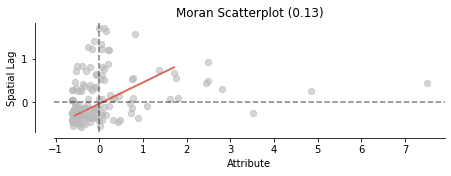

In [58]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

Based on the results of the Moran value for this variable of roughly .13, there appears to be a slightly positive spatial autocorrelation. The values range from -1 to 1, so this value is not significantly positve. When looking at the plot, there is a significant density of LL areas that contributes to the positive spatial autocorrelation.

Next, we will conduct simulation on the Moran values and distribution.

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:47: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

/opt/conda/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:48: MatplotlibDeprecationWarning:


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.



(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efbf9e741f0>)

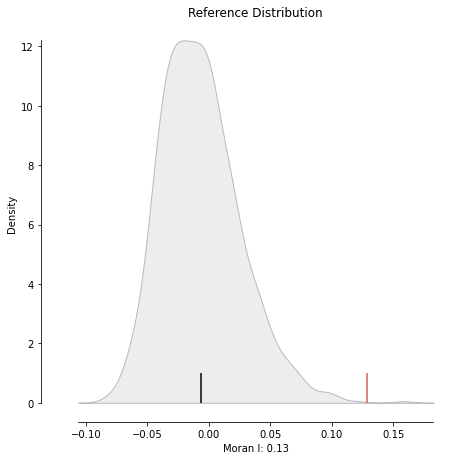

In [59]:
# make plot of moran simulation
plot_moran_simulation(moran,aspect_equal=False)

In [60]:
# find simulated moran value
moran.p_sim

0.002

Based on the results of the simulation, we got a value of .001 and the distribution is roughly centered around 0. This statistically significant p value shows that, although the autocorrelation is not particularly positive, the distribution of the map is not random.

Next, we will look at the local Moran values to determine the local spatial autocorrelation. We will do so by making the Moran values and making plots with the results.

In [61]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

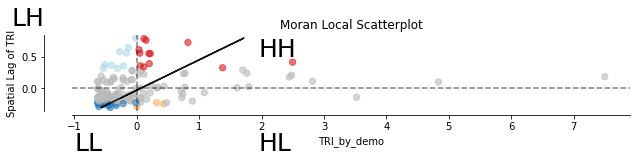

In [62]:
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("TRI_by_demo")
ax.set_ylabel('Spatial Lag of TRI')

# add labels for categories
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

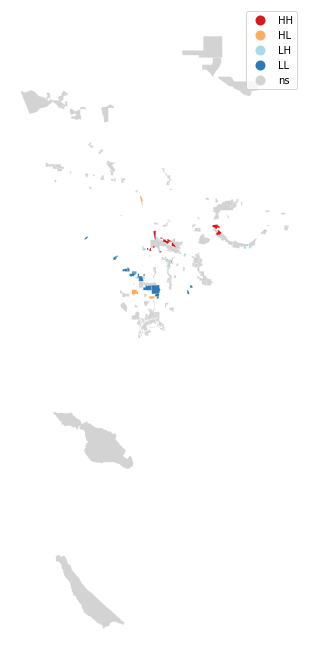

In [63]:
# make plot from lisa 
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, blocks_Race1, p=0.05, ax=ax)
plt.show()

As we can see from the scatterplot, the slope of the fit line is roughly the same. However, many of the block groups are not significantly correlated to its surroundings. This is shown through the many grey dots on the scatterplot and the map. This is likely because of the amount of block groups that are not included in the data. It would be difficult to establish correlation between nearby block groups when there are so many spaces left out. As a result, I will try to combine this data set with the other data sets I have worked with (which include other environmental statistics like emissions, water contaminants, etc.) in order to include each of the block groups in LA County. This way we could get a clearer picture of environmental racism.

There are, however, a few significant clusters shown. There is a cluster of LL areas around Compton, in which the nearby groups all have low TRI weighted by percent Hispanic. This is in part because of the lower rates of Hispanics (though higher rates of black residents) and in part due to lower toxic release. On the other hand, the aforementioned Hacienda Heights and East LA areas both have instances of HH. This shows that there are concentrated areas of Hispanic residents that are experiencing the effects of environmental racism. I chose to analyze based on percentages of Hispanic and Latino residents because they have been shown to be particularly affected in my research. There are also instances of massive toxic release in communities that are entirely American Indian. In another attempt at spatial analysis of toxic release by population, the highest value came from a small block group that was entirely American Indian with roughly 28,000 lbs of toxic release. Though this spatial analysis is not yet the most effective analysis of environmental racism in LA County, it does confirm my other research to an extent.

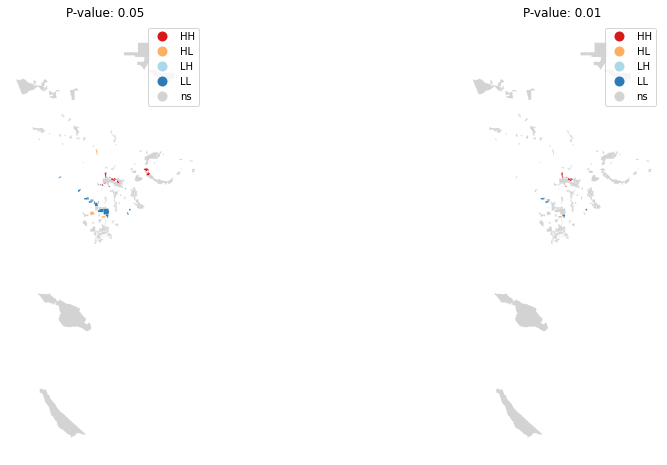

In [64]:
# create 2 subplots for spatial lag maps
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# p value .05 for left plot
lisa_cluster(lisa, blocks_Race1, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# p value .01 for right plot
lisa_cluster(lisa, blocks_Race1, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

From the results of these side-by-side plots, it is clear that the spatial autocorrelation is relatively weak in most areas. While the results from the p-value=.05 plot were not particularly encouraging, the .01 plot shows that there are few ares that we can be confident are spatially correlated. However, some of the East LA and SE LA values remained in the more restrictive plot. Again, with a more thorough and complete dataset for the entirety of Los Angeles County would allow for more confident and significant results, which I will work towards in the coming days.